# Inferential Statistics

By calculating descriptive statistics and plotting data visualizations, we may see differences in data observed in different conditions. However, before we conclude that there is a real difference, we must first consider the possibility that we are not observing true differences, but instead differences due to chance. We can test this possibility using inferential statistics.

## Simulation: no real effect

First, we'll simulate a case where there are two conditions, but no actual difference between them. For example, say we had an hypothesis, for some reason, that people born on an even-numbered day have higher IQ than people who were born on an odd-numbered day. There is no actual relationship between birthday parity and IQ, so the IQ distribution would be the same for both groups, given a large enough sample size.

*But we still might observe a difference between the mean IQ of the two conditions*. This happens sometimes due to random chance.

IQ follows an approximately normal distribution with a mean of 100 and a standard deviation of 15. In our simulation, people with even birthdays and odd birthdays will be drawn from the same distribution; that is, there is no actual difference in IQ. So, we will set the mean and standard deviation of the IQ distribution to be the same for the two conditions.

In [1]:
mu1, sigma1 = 100, 15
mu2, sigma2 = 100, 15

The probability distributions for the simulated conditions are plotted below.

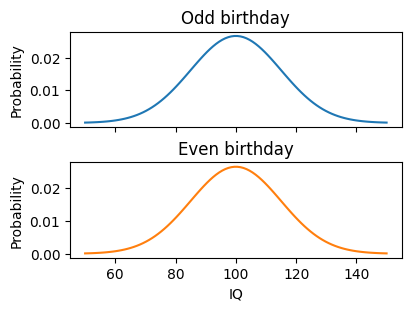

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
iq_vals = np.linspace(50, 150, 100)
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(4, 3), constrained_layout=True)
ax[0].plot(iq_vals, stats.norm.pdf(iq_vals, mu1, sigma1))
ax[0].set_title("Odd birthday")
ax[0].set_ylabel("Probability")
ax[1].plot(iq_vals, stats.norm.pdf(iq_vals, mu2, sigma2), color="C1")
ax[1].set_title("Even birthday")
ax[1].set_ylabel("Probability")
ax[1].set_xlabel("IQ");

To actually test our (weird, incorrect) hypothesis that people with even-numbered birthdays have higher IQ, we need to collect some observations. Say that we recruit 25 people with even birthdays and 25 people with odd birthdays, and use a standard assessment to measure their IQ.

We can simulate this study by randomly sampling from the even and odd IQ distributions. Even though the two IQ distributions are exactly the same, when we generate samples of IQ, we will sometimes end up with a difference in the mean value of IQ in the two samples.

In [3]:
rng = np.random.default_rng(10)
n1, n2 = 25, 25
iq1 = rng.normal(mu1, sigma1, size=n1)
iq2 = rng.normal(mu2, sigma2, size=n2)

Depending on the random number generator seed we use, we will get different "random" values. It turns out that, when we use a seed of 10, we happen to sample two distributions that look a little different.

Let's package our simulated data into a DataFrame using Polars and use Seaborn's `displot` function to visualize the two samples.

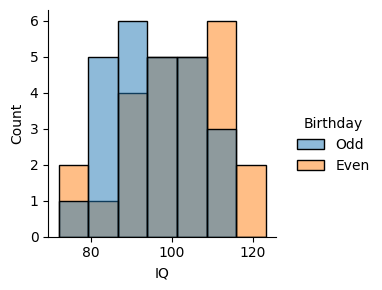

In [4]:
import polars as pl
import seaborn as sns
df = pl.DataFrame(
    {
        "IQ": np.concat([iq1, iq2]), 
        "Birthday": np.repeat(["Odd", "Even"], [n1, n2]), 
    }
)
sns.displot(df, x="IQ", hue="Birthday", height=3);

The mean value of `IQ` looks somewhat different in the two conditions, even though they were drawn from the same distribution.

In [5]:
(
    df.group_by("Birthday")
    .agg(pl.col("IQ").mean())
    .sort("Birthday")
)

Birthday,IQ
str,f64
"""Even""",100.309842
"""Odd""",94.930247


Apparently, being born on an even day makes your IQ about 5 points higher!

Sometimes, it may look like there is an effect, even when there really isn't, just due to chance. How can we tell whether an effect is due to a real difference, or just due to random variability?

## Null hypothesis significance testing

There's never really a guarantee that a difference between conditions on some measure is real. However, we can use statistics to minimize the possibility of being led astray by random chance. The most common approach to testing hypotheses using statistics is called *null hypothesis significance testing*, or NHST.

In the NHST approach, we start by considering the possibility that there is no effect. If we are interested in the potential effect of some independent variable on some dependent variable, we must consider the possibility that the independent variable does *not* influence the dependent variable.

With the null hypothesis in mind, we examine the data we observed, and use a statistical test to calculate a *$p$-value*. The $p$-value is the probability of having observed a set of measurements, assuming the *null hypothesis* that there is no difference between conditions.

Let's go back to the simulation example from before. Here are the IQ distributions for the two conditions (even birthday and odd birthday) again.

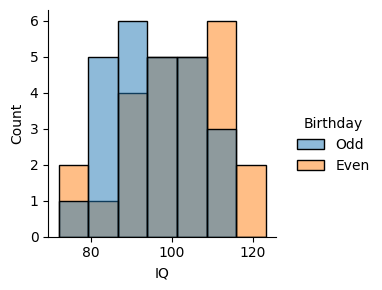

In [6]:
sns.displot(df, x="IQ", hue="Birthday", height=3);

In our simulation, the 25 people with even birthdays have higher IQ, on average, than the 25 people with odd birthdays. However, because this is our simulation, we know that the null hypothesis is true; there is no real effect of birthday parity. Given that, how likely is it to observe a difference between samples like this? We will calculate a $p$-value to answer this question, using a method called a *$t$-test*.

## Running a $t$-test

Next, we will work through an example of the calculations involved in running a *t*-test. The goal is to start building an understanding of how a $t$-test works and how it is used to estimate a $p$-value for the difference between two conditions. In practice, we won't usually run through all these calculations manually.

To measure an effect we need to take two things into account: (1) the difference of the means of the two conditions, and (2) the spread of the means of each condition. Both of these factors affect how much the samples overlap. If there is a lot of overlap between the samples, then we can conclude that any differences might just be due to chance.

First, we need to calculate the difference in the mean dependent variable (IQ) between our two conditions (even birthday and odd birthday).

In [7]:
diff = np.mean(iq2) - np.mean(iq1)
print(diff)

5.379595626031403


Next, we need to calculate the standard error of the mean (SEM) for each sample. This provides a measure of how much we should expect the mean to vary if we take repeated samples.

In [8]:
sem1 = np.std(iq1, ddof=1) / np.sqrt(n1)
sem2 = np.std(iq2, ddof=1) / np.sqrt(n2)
print(sem1, sem2)

2.1275119423120703 2.606465143468669


Finally, we calculate the $t$-statistic, which we will use to estimate the $p$-value.

In [9]:
t = diff / np.sqrt(sem1 ** 2 + sem2 ** 2)
print(t)

1.5989211222692934


If the null hypothesis is true, then the $t$-statistic will have a specific distribution. We can see that by running a little simulation. We'll repeat our experiment of drawing two samples with the same mean and standard deviation and calculating the $t$-statistic for each sample. If we repeat this process many times, we'll see a characteristic shape that is similar to a normal distribution but varies in shape depending on how many samples we have.

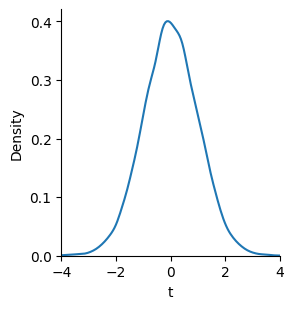

In [10]:
N = 10000
ts = np.zeros(N)
for i in range(N):
    _iq1 = rng.normal(mu1, sigma1, size=n1)
    _iq2 = rng.normal(mu2, sigma2, size=n2)
    ts[i] = (np.mean(_iq1) - np.mean(_iq2)) / np.sqrt(np.var(_iq1, ddof=1) / n1 + np.var(_iq2, ddof=1) / n2)
sns.displot(ts, kind="kde", height=3).set(xlim=(-4, 4), xlabel="t");

Fortunately, we don't have to run simulations to get this distribution. Statisticians have found that it follows a specific mathematical form called a $t$-distribution. We can compare the $t$-value for our sample to the probability distribution for $t$-statistics to see how likely we would observe it under the null hypothesis.

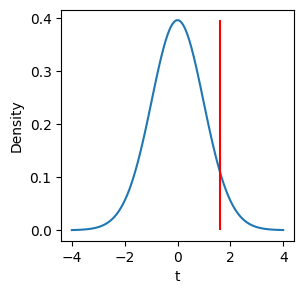

In [11]:
tx = np.linspace(-4, 4, 100)
ty = stats.t.pdf(tx, n1 + n2 - 2)
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(tx, ty)
ax.vlines(t, 0, np.max(ty), color="r");
ax.set_xlabel("t")
ax.set_ylabel("Density");

The shape of the $t$-distribution changes depending on the *degrees of freedom*, calculated as $N_1 + N_2 - 2$, where $N_1$ and $N_2$ are the size of the first sample and the second sample.

We can use the cumulative distribution function of $t$ to calculate the probability of observing a value at least as extreme as our $t$-value. This is the $p$-value.

In [12]:
p = (1 - stats.t.cdf(t, n1 + n2 - 2)) * 2
print(p)

0.11640075282849471


Here, we have used a *two-sided test*, which doesn't assume any specific direction that an effect will take. We consider the possibility that IQ is greater for even birthdays or for odd birthdays.

## Interpreting the $p$-value

The $p$-value represents the probability of having observed a difference in means as extreme as the one we observed in our sample, assuming that there is no effect. This is *not* the probability that our observations are due to chance. Instead, it is the probability of our observations occurring *assuming* that they are due to chance.

When the $p$-value is small, we may decide to *reject the null hypothesis*. In psychology, the usual standard is that we decide to reject the null hypothesis when $p < 0.05$. This means that, if the null hypothesis is true, we will have a *false positive* (that is, a false rejection of the null hypothesis) less than 5% of the time.

The use of null hypothesis significance testing and $p$-values is famously counterintuitive. Remember to be careful when thinking about the meaning of $p$-values, and look up the definition periodically to remind yourself how it is defined.

## Using Pingouin

We don't have to make $t$-test calculations by hand, of course. The Pingouin package has a number of functions to calculate various statistical tests.

We can use the Pingouin `ttest` function to run a $t$-test and provide a table of related statistics.

In [13]:
import pingouin as pg
pg.ttest(iq1, iq2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.598921,48,two-sided,0.116401,"[-12.14, 1.39]",0.452243,0.798,0.347368


Here, we would say that we used a t-test to compare the two conditions, and $p>0.05$, so we conclude that there is not a *statistically significant* difference between conditions. The lack of a significant t-test does not prove that there is no difference between the conditions. Instead we say that we *did not reject the null hypothesis*. It's always possible that there is some difference, but we would have needed a larger sample to detect it.

Pingouin also returns some other statistics related to the t-test, including a column called `cohen-d`. This is a measure of *effect size*. 

## Effect size

While a p-value varies depending on the size of your sample, effect sizes are simpler and just provide an estimate of how big the relative difference is between conditions.

There are different measures of effect size for different statistical tests. For a $t$-test, we can use the *Cohen's $d$* measure of effect size. That is the difference between the means divided by an estimate of the standard deviation, pooled across the two samples.

In [14]:
d = diff / np.sqrt((np.var(iq1, ddof=1) + np.var(iq2, ddof=1)) / 2)
print(d)

0.45224318725560886


To give a rough idea of what different magnitudes of effect sizes mean, Cohen suggested interpreting values of $d$ as "small" (around 0.2), "medium" (around 0.5), or "large" (around 0.8).

When reporting the results of a statistical test, it is a good idea to include a measure of effect size to provide an estimate of how large the difference between conditions is.

### Exercise: null hypothesis is true

Before, we ran one simulation of a t-test. We randomly generated two samples of IQ from two different conditions and then ran a t-test, to get a p-value estimating the probability of observing a given difference in IQ under the null hypothesis. Because the actual distribution was the same for the two groups, that meant the null hypothesis was true.

Given the random number generated defined below, and the mean and standard deviation for different simulated conditions, try generating random data and using a t-test to check for a difference between conditions. You can run a t-test using `pg.ttest`. Compare the randomly generated IQ scores in the `iq1` and `iq2` variables. Run your code multiple times (if you don't reset the RNG, you will get a different answer each time you run it). See how it changes each time. You should get a "significant" result ($p<0.05$) about 1 time out of 20, even though there is no real difference between conditions.

#### Advanced

Plot your distributions using Seaborn's `displot` function. If you pass in a list of arrays, it will plot them in different hues.

In [15]:
rng = np.random.default_rng(10)

In [16]:
mu1, sigma1 = 100, 15
mu2, sigma2 = 100, 15
n1, n2 = 25, 25
iq1 = rng.normal(mu1, sigma1, size=n1)
iq2 = rng.normal(mu2, sigma2, size=n2)
# your code here

### Exercise: null hypothesis is false

Now try running a simulation where the null hypothesis is false, because there actually is a difference in mean IQ in the two conditions. Set the mean for condition 1 to be 110 by setting `mu1` to 110 and run a t-test comparing `iq1` and `iq2`. How often do you see a significant difference ($p<0.05$) now? 

What happens if you increase the sample size by changing `n1` and `n2` to 50 instead of 25? 

What happens if you increase the standard deviations by setting `sigma1` and `sigma2` to 30?

In [17]:
mu1, sigma1 = 100, 15
mu2, sigma2 = 100, 15
n1, n2 = 25, 25
iq1 = rng.normal(mu1, sigma1, size=n1)
iq2 = rng.normal(mu2, sigma2, size=n2)
# your code here

## Pingouin statistical tests

The Pingouin package is designed to make it easier to run various statistical tests, including various kinds of $t$-tests. There are many different ways to use NHST to test various hypotheses, but we will focus on a few common tests that are used in psychology research.

one-sample t-test
: test whether a distribution has some specific mean

two-sample paired t-test
: test whether two conditions, measured within subjects, have the same mean

one-way repeated-measures ANOVA
: test whether two or more conditions, measured within subjects, have the same mean

two-way repeated-measures ANOVA
: test whether two within-subject factors, each of which may have multiple groups, have the same means

We will use the `study.csv` file to illustrate these examples.

In [18]:
study = (
    pl.read_csv(
        "study.csv", null_values="n/a", schema_overrides={"item_type": pl.String}
    )
    .with_columns(
        pl.col("item_type").replace({"1": "word", "2": "picture"}),
    )
)
study.head()

participant_id,trial_type,item_type,response,response_time
i64,str,str,i64,f64
1,"""target""","""word""",1,1.5
1,"""lure""","""picture""",0,2.3
1,"""target""","""picture""",1,1.7
1,"""target""","""word""",0,2.2
1,"""lure""","""picture""",1,1.8


### Exercise: dataset preparation

We'll use the Osth & Fox (2019) study for some exercises on running inferential statistical tests. We will focus on the test phase.

First, we'll load the data and clean it to handle missing responses and recode one of the columns.

In [19]:
from datascipsych import datasets
test = (
    datasets.clean_osth(pl.read_csv(datasets.get_dataset_file("Osth2019")))
    .filter(pl.col("phase") == "test")
)

Next, we calculate the mean response in various conditions. We will use these results to demonstrate t-tests and a one-way ANOVA.

In [20]:
p_old_probe = (
    test.group_by("subj", "probe_type")
    .agg(pl.col("response").mean())
    .sort("subj", "probe_type")
)
p_old_targets = p_old_probe.filter(pl.col("probe_type") == "target")
p_old_lures_lag = (
    test.filter(pl.col("probe_type") == "lure")
    .group_by("subj", "lag")
    .agg(pl.col("response").mean())
    .sort("subj", "lag")
)

Finally, we will calculate how response time varies based on the probe type and response, to use for an example of a two-way ANOVA.

In [21]:
rt = (
    test.filter(pl.col("RT").is_not_null())
    .with_columns(pl.col("response").cast(pl.String).replace({"0": "new", "1": "old"}))
    .group_by("subj", "probe_type", "response")
    .agg(pl.col("RT").mean())
    .sort("subj", "probe_type", "response")
)

## One-sample t-test

We can use a one-sample t-test to examine whether a measure is different from some null value. For example, when participants see a word and must choose whether it is "old" or "new", they have a 50% chance of getting it correct. We can use a t-test to test whether targets are responded to correctly more than expected due to chance.

First, we get target trials and calculate the mean response to get accuracy.

In [22]:
m_target = (
    study.filter(pl.col("trial_type") == "target")
    .group_by("participant_id")
    .agg(pl.col("response").mean())
    .sort("participant_id")
)
m_target

participant_id,response
i64,f64
1,0.75
2,0.75
3,1.0


Next, we use a one-sample t-test to test whether the response accuracy is greater than 0.5. The first input give the data for the measure we are interested in, and the second input gives the mean that we would expect due to chance.

In [23]:
pg.ttest(m_target["response"], 0.5)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.0,2,two-sided,0.057191,"[0.47, 1.19]",2.309401,2.358,0.564514


Although accuracy is fairly high (75%, 75%, and 100%, for the three participants), $p > 0.05$, so we conclude that there is not a significant effect here (that is, we do not reject the null hypothesis). That isn't surprising, because three participants is a very small sample size, so even three high-performing participants is not very strong evidence that the overall population of participants performs above chance on average.

By default, the t-test evaluates whether the observed data are either greater than or less than what is expected due to chance. Here, we are probably only interested in whether the response is *greater* than 0.5, not *less* then 0.5, because we would not normally expect participants to perform worse then chance level. If they were guessing randomly, they would still get 50% of trials correct on average.

We can test for a specific direction of effect by setting the optional `alternative` input to `ttest`. Here, we'll use `"greater"` to test the *alternative hypothesis* that the responses are greater than 0.5.

In [24]:
pg.ttest(m_target["response"], 0.5, alternative="greater")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.0,2,greater,0.028595,"[0.59, inf]",2.309401,4.717,0.803159


You should only test for a specific direction of effect if you have a clear justification for why only that direction makes sense. If, before looking at the data, you are not sure which direction an effect will take, use the default "two-sided" test. A two-sided test considers any differences from the null value, either greater or less.

### Exercise: one-sample t-test

Given data from the Osth & Fox (2019) study, defined below as the `p_old_targets` DataFrame, use `pg.ttest` to test whether the probability of responding "old" on target trials is different from chance (0.5) using a t-test. Do you reject the null hypothesis? How large is the effect size?

Now test the specific hypothesis that the probability of responding "old" is *greater* than chance (0.5).

Visualize the responses using a histogram.

In [25]:
p_old_targets.head(2)

subj,probe_type,response
i64,str,f64
101,"""target""",0.76569
102,"""target""",0.2875


In [26]:
# your code here

## Two-sample paired t-test

In studies with within-subject designs, each participant completes two or more conditions. In this type of design, we can ask whether participants have different behavioral measures on the two conditions.

We'll examine whether response times were different for target and lure trials. We first need to get the data into shape. A pivot table works well to arrange the data so we can access measures from both conditions.

In [27]:
df = (
    study.drop_nulls()
    .pivot("trial_type", index="participant_id", values="response_time", aggregate_function="mean")
)
df

participant_id,target,lure
i64,f64,f64
1,1.75,2.1
2,1.425,2.125
3,1.766667,2.525


To complete a paired t-test, we pass the two samples (target and lure) and indicate that they are `paired`. That is, the target and lure arrays are matched up, so that scores in the same position come from the same participant.

In [28]:
pg.ttest(df["target"], df["lure"], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.727456,2,two-sided,0.04195,"[-1.15, -0.05]",2.78068,2.839,0.693374


In this case, $p<0.05$, so we conclude that there is a significant effect of trial type (target vs. lure). Of course, we only have three participants, so we should not be too confident about this result until we have a larger sample of people.

### Exercise: two-sample paired t-test

In the Osth & Fox (2019) study, we can calculate the probability of responding "old" separately for target and lure trials. We can use a paired t-test to check if this probability is different between target and lure trials, taking into account that they collected "repeated measures" where both target P(old) and lure P(old) were measured for each subject.

Given the `responses` DataFrame defined below, use `pg.ttest` to run a two-sample paired t-test to test if there is a significant difference in the probability of making an "old" response between the target and lure trials. How large is the effect size?

Visualize the mean response for target and lure trials using a bar plot.

In [29]:
responses = p_old_probe.pivot("probe_type", values="response", index="subj")
responses.head(2)

subj,lure,target
i64,f64,f64
101,0.108333,0.76569
102,0.241667,0.2875


In [30]:
# your code here

## One-way repeated-measures ANOVA

Analysis of variance (ANOVA) tests can be used to test whether multiple groups have the same means.

If the factor varies within subject, we must use a repeated-measures ANOVA. This works similarly to a paired t-test, but allows for more than two groups. If there are two groups, usually we will use a paired t-test, but a repeated-measures ANOVA will give exactly the same p-value.

Pingouin is not yet fully compatible with Polars, so we must convert our Polars DataFrame to a Pandas DataFrame to run the `rm_anova` function. We can do this using `to_pandas()`, which takes a Polars DataFrame and returns a Pandas DataFrame. In the future, Pingouin will probably be updated so this conversion step will not be necessary.

In [31]:
study_pd = study.to_pandas()
type(study_pd)

pandas.core.frame.DataFrame

Now that we have a Pandas-format DataFrame, we can run `rm_anova` to test if there is a significant difference in response time between the different trial types. We must specify columns for `dv` (the dependent variable), `within` (the within-subject variable), and `subject` (the column with subject identifiers). In this example, there were only two trial types, but we can apply the same analysis to cases where there are more than two groups.

In [32]:
pg.rm_anova(data=study_pd, dv="response_time", within="trial_type", subject="participant_id")

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,trial_type,1,2,22.348837,0.04195,0.743561,1.0


Like with the $t$-tests we used before, the ANOVA gives us a $p$-value (in the `p-unc` column). In the context of an ANOVA, it means the probability of having observed a difference between conditions like the one we observed, assuming that the null hypothesis that all conditions have the same distribution. Here, because $p<0.05$, we reject the null hypothesis and conclude that there is a significant difference between groups. The `ng2` column gives *generalized eta squared*, a measure of effect size for ANOVAs. It measures how large of a difference there is between groups.

Notice that now we have an $F$ statistic instead of a $t$-statistic. The $F$ statistic has two degrees of freedom (often written as DOF or DF) that determine the shape of its distribution, instead of one. The ANOVA uses a different method compared to t-tests, but ANOVA results have all the same basic parts.

| test type | test statistic  | effect size                       |
| --------- | --------------- | --------------------------------- |
| $t$-test  | $t(df)$         | Cohen's $d$                       |
| ANOVA     | $F(df_1, df_2)$ | $ng^2$ (generalized eta-sequared) |

### Exercise: one-way repeated-measures ANOVA

Use a one-way repeated-measures ANOVA to test whether the probability of making a false alarm to a lure varies with lag.

Given the Polars DataFrame `p_old_lures_lag`, use the `pg.rm_anova` function to run a one-way repeated-measures ANOVA with `lag` as a within-subject factor and `response` as the dependent variable (`dv`). Is there a significant effect of lag?

Hint: remember that some Pingouin functions are currently not compatible with Polars DataFrames and must take Pandas DataFrames instead.

Visualize how response varies with lag using a line plot.

In [33]:
p_old_lures_lag.head(5)

subj,lag,response
i64,i64,f64
101,1,0.0625
101,2,0.1875
101,3,0.0625
101,4,0.125
101,5,0.104167


In [34]:
# your code here

## Two-way repeated-measures ANOVA

We can use a two-way ANOVA instead if there are two factors that were are interested in.

For example, say we want to test whether trial type, item type, or some combination of both factors, influence response time. Let's visualize these variables using a bar plot.

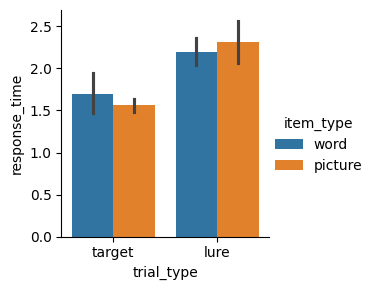

In [35]:
sns.catplot(data=study, x="trial_type", y="response_time", hue="item_type", kind="bar", height=3);

We can run an ANOVA to test for the following:

A main effect of trial type. This would indicate that trial type has an effect on response time, regardless of item type.

A main effect of item type. This would indicate that item type has an effect on response time, regardless of trial type.

An interaction. This would indicate that the effect of one variable on response time is dependent on the other variable.

Because the variables of interest are within-subject, we again use a repeated-measures ANOVA. We can also use `rm_anova` to run a two-way ANOVA.

In [36]:
pg.rm_anova(data=study_pd, dv="response_time", within=["trial_type", "item_type"], subject="participant_id")

/Users/morton/VSCode/datascipsych/.venv/lib/python3.13/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/morton/VSCode/datascipsych/.venv/lib/python3.13/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,trial_type,1.171875,1,2,1.171875,23.734177,0.039645,0.039645,0.734622,1.0
1,item_type,0.000208,1,2,0.000208,0.007874,0.937378,0.937378,0.000492,1.0
2,trial_type * item_type,0.046875,1,2,0.046875,3.571429,0.199359,0.199359,0.099690,1.0


Note that this time, we have three p-values instead of one! There are three tests, which correspond to the two main effects and the interaction. In this case, we could conclude that there is a main effect of trial type ($p<0.05$), no main effect of item type ($p>0.05$), and no interaction ($p>0.05$).

Pingouin includes two different sets of $p$-values: standard $p$-values and Greenhouse-Geisser corrected $p$-values. The Greenhouse-Geisser correction takes into account the fact that the dependent variable may be more correlated for some groups than for others. See the [Pingouin documentation](https://pingouin-stats.org/build/html/generated/pingouin.rm_anova.html) for more information.

### Exercise: two-way repeated-measures ANOVA

Given the Polars DataFrame `rt`, use a two-way repeated-measures ANOVA to test whether `RT` varies with `probe_type` and `response`. Is there a main effect or probe type? A main effect of response? An interaction?

Visualize how response varies with probe type and response using a bar plot.

In [37]:
rt.head(4)

subj,probe_type,response,RT
i64,str,str,f64
101,"""lure""","""new""",1.913257
101,"""lure""","""old""",2.0125
101,"""target""","""new""",1.850839
101,"""target""","""old""",1.584497


In [38]:
# your code here

## Summary

We used a simulation to demonstrate how apparent differences between conditions can sometimes occur due to chance. We can use null hypothesis significance testing (NHST) to reduce false positives where we conclude that there is a difference, even when there isn't one. To do this, we use run a statistical test and reject the null hypothesis if $p < 0.05$.

There are many different types of hypothesis tests, depending on how many conditions we want to compare and whether the conditions are within- or between-subject. Here, we focused on within-subject effects, but there are also tests for comparing groups of subjects that completed different conditions. See the [Pingouin documentation](https://pingouin-stats.org/build/html/api.html) for details about more inferential statistics.